<a href="https://colab.research.google.com/github/gchase15/NueralNetBasics/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super(AlexNet,self).__init__()     
        # Define the layers
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels =96, kernel_size = 11, stride = 4, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )  
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(9216,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        ) 
        # initialize bias        
        self.init_bias()
    def init_bias(self):
        # Initialize weights according to original paper
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        x = self.net(x)
                # reduce the dimensions for linear layer input
        x = x.view(-1, 9216)  
        return self.classifier(x)

In [3]:
!git clone https://github.com/gchase15/NueralNetBasics.git

Cloning into 'NueralNetBasics'...
remote: Enumerating objects: 25031, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 25031 (delta 0), reused 12 (delta 0), pack-reused 25018
Receiving objects: 100% (25031/25031), 541.74 MiB | 34.38 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (25014/25014), done.


In [7]:
# Set the seed value
seed = torch.initial_seed()

# create model
model = AlexNet()
# create dataset and data loader
train_batch_size = 32
dataset = datasets.ImageFolder("/content/NueralNetBasics/train", 
        transforms.Compose([
        transforms.CenterCrop((227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))
#uns_data = dataset.unsqueeze(0)
train_set, cv_set = torch.utils.data.random_split(dataset, [22000, 3000])

trainloader = data.DataLoader(
        train_set,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        batch_size=train_batch_size)
cvloader = data.DataLoader(
        cv_set,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        batch_size=train_batch_size)

# Define loss function
loss_fn = nn.CrossEntropyLoss()
# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
# start training
epochs = 10
correct = 0
accuracy_list = np.zeros((epochs,))
train_losses = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.view(train_batch_size,3, 227, 227)
        optimizer.zero_grad()
        out = model(images)
        loss = loss_fn(out,labels)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for i, (images, labels) in enumerate(cvloader):
            images = images.view(train_batch_size,3, 227, 227)
            labels = Variable(labels)
            y_pred = model(images)
            correct += (torch.argmax(y_pred, dim=1) == labels).sum()
        accuracy = correct / 2944
        accuracy_list[epoch] = accuracy  
        correct = 0


([<matplotlib.axis.YTick at 0x7f8f5fd2dd50>,
 <a list of 19 Text major ticklabel objects>)

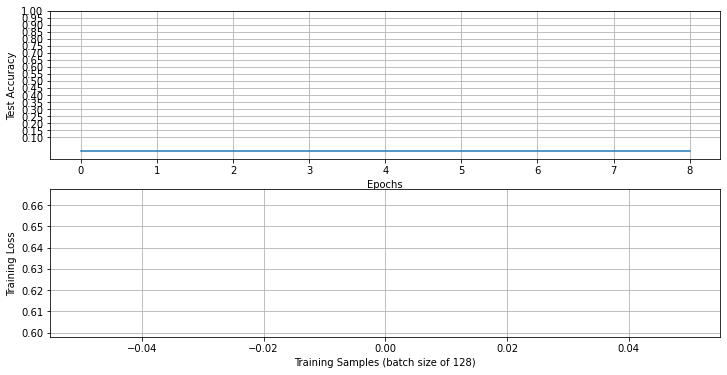

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)
ax1.plot(accuracy_list[1:])
ax1.set_ylabel("Test Accuracy")
ax1.set_xlabel("Epochs")
ax1.grid()
#ax1.tick_params(labelcolor='w')
ax2.plot(train_losses)  
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("Training Samples (batch size of 128)")

#ax2.tick_params(labelcolor='w')
ax2.grid()
plt.sca(ax1)
plt.yticks(np.arange(0.1,1.05, step=0.05))

In [13]:
print(accuracy_list)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
